# Modeling Personal Loan Delinquency with LendingClub Data

The domain of our project is peer-to-peer consumer lending. Our goal is to model credit risk on personal loans, more precisely to evaluate the probability of default or delinquency of borrowers during their loan period.

LendingClub loans are made over either a 36 or 60 month term, with a variety of statistics reported about each unique loan on a monthly basis (our analysis focuses on the 36 month terms). Our variable of interest is called `loan_status` which has eight possible states. We attempt to model credit risk by estimating the probability of a loan transitioning between any two of these states at any month during the loan term. Below are the eight `loan_status` states, with descriptions from LendingClub's [website](https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-):

- **Issued**: New loan that has passed all LendingClub reviews, received full funding, and has been issued.

- **Current**: Loan is up to date on all outstanding payments. 

- **In Grace Period**: Loan payment is late, but within the 15-day grace period.
 
- **Late (16-30)**: Loan is late, past the grace period, hasn't been current for 16 to 30 days.
 
- **Late (31-120)**: Loan has not been current for 31 to 120 days.
 
- **Charged Off**: Loan for which there is no longer a reasonable expectation of further payments. Charge Off typically occurs when a loan is 120 days or more past due and there is no reasonable expectation of sufficient payment to prevent the charge off. Loans for which borrowers have filed for bankruptcy may be charged off earlier.

- **Default**: Loan has not been current for an extended period of time. Charged off and default states are similar, yet different. [TODO explain]

- **Fully paid**: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

To model the transition states month over month, we employed a stationary discrete time step Markov Chain model. Discrete because our data is on a monthly basis, and stationary because we assume the probability distribution of  transition is independent of time (we use the same model across all month). Recall the Markov property, or the "memoryless" assumption, that for some sequence of events, that the conditional probability of the next time step $x_t$ depends only upon the previous time step $x_{t-1}$, ignoring all time steps that preceded it:

$$
\begin{align*}
p(X_t = x_t | X_{t-1} = x_{t-1}, X_{t-2} = x_{t-2}, ... , X_0 = x_0) = p(X_t = x_t | X_{t-1})
\end{align*}
$$

For a discrete time Markov Chain, the joint distribution for the probability of some sequence length $T$ can then be written as:

$$
\begin{align*}
p(X_{1:T}) = p(X_1)p(X_2 | X_1) p(X_3 | X_2) ... = p(X_1)\prod_{t=2}^{T}p(X_t | X_{t-1})
\end{align*}
$$

[Murphy, 2012, p. 589](#References)

For $K$ outcome states, the conditional distribution $p(X_t | X_{t-1})$ can be written as a $K \times K$ transition matrix (denoted $A$) where $A_jk  = p(X_t = k | X_{t-1} = j)$ (the probability of transitioning from states $j$ to state $k$, where each row in the matrix can be thought of as a probability mass function). In our case $K=8$ and we have an $8 \times 8$ transition matrix. The goal of our analysis, then, is to estimate the posterior probabilities of this transition matrix using our observed data.

## Data

Our dataset consists of approximately 40 million observations from loans spanning between 2007 through Q3 2018. The dataset includes dozens of fields, however for our Markov model (and to simplify data management) we only need to work with 4 features: `id`, `loan_status`, `term`, and `age_of_loan`. During preprocessing, we also filtered out all loans with a 60 month term and 36 term loans that extended beyond 36 months, reducing our dataset to around 27 million observations. In total, we have just under 1.5 million unique loans, which can be seen in the rows column after we split and pivot our data below.

In [1]:
from utils.utils import load_dataframe, preprocess, split_data
from utils.models import build_mle_matrix, build_mc_no_priors, build_mc_with_priors
from utils.inference import compute_mle, infer_mc_no_priors, infer_mc_with_priors
from utils.criticism import sample_mle, plot_sampled_lengths
import numpy as np

In [2]:
df = load_dataframe()

Loading raw data from cache...
Retrieved 40,263,987 rows, 4 columns in 4.08 seconds


In [3]:
df = preprocess(df)

Mapping column names...
Loading preprocessed data from cache...
Retrieved 27,636,875 rows, 4 columns in 3.07 seconds


In [4]:
x_train, x_test = split_data(df)

Loading split data from cache...
Retrieved 1,486,122 rows, 36 columns in 0.72 seconds
Train: (1337480, 36) | Test: (148642, 36)


In [5]:
chain_len = max(df.age_of_loan)
n_states = df.loan_status.unique().shape[0]

## Experiment 1: Markov Model with Maximum Likelihood Estimates

We start with a simple model which is a Markov Model, which is stationary and homogeneous: the transitions between states are the same for all loans, and don't vary with time. We will keep this model for several experiments, as inference can be quite challenging even on this simpel model.

Even though we want to solve the problem from a Bayesian perspective, our first idea is to estimate the model with MLE estimates, which are easy to obtain and give us a robust baseline.

### 1.1 Model

To get some intuition on how to estimate the transition matrix given our training data, $N$, we start with MLE estimation. The MLE solution of a Markov Chain is simply the empirical frequencies of each transition. Formally, the probability of some particular sequence length $T$, with transition matrix $M$ and states $K$ is given by: 

$$ 
\begin{align*}
p(x_{1:T}|\theta) = p(x_1)A(x_1, x_2)...A(x_{T-1}, x_T) 
&= \prod_{j=1}^{K}(p_j)^{\mathbb{I}(x_1 = j)} \prod_{t=2}^{T} \prod_{j=1}^{K} \prod_{k=1}^{K}(A_{jk})^{\mathbb{I}(x_{t-1} = j, x_t = k)}
\end{align*}
$$

It is relatively easy to show that the MLEs for $p_j$ (at state $j$) and $T_{jk}$ (at transition from states $j$ to $k$) are given by the observed frequencies:  
$$ 
\begin{align*}
p_j = \frac{\sum_{i=1}^N\mathbb{I}(x_{i1} = j)}{\sum_{j}\sum_{i=1}^N\mathbb{I}(x_{i1} = j)}
\end{align*}
$$

$$ 
\begin{align*}
A_{jk} = \frac{\sum_{i=1}^N\sum_{t=1}^{T-1} \mathbb{I}(x_{i,t} = j, x_{i,t+1} = k)}{\sum_k\sum_{i=1}^N\sum_{t=1}^{T-1} \mathbb{I}(x_{i,t} = j, x_{i,t+1} = k)}
\end{align*}
$$

[Murphy, 2012, pp. 592–593](#References)

In more colloquial terms, the estimator for $p$ in any given outcome state $j$ is the number of times we observed $j$ at time $t=1$ in our training data, divided by the total number of observations at time $t=1$. Similarly, the estimator for $A$ of transitioning from state $j$ to state $k$ is given by the total number of times we observed a transition from state $j$ to state $k$, divided by the total number of times we observed a transition from state $j$ to any other state. For our purposes, we ignore $p$ and just generate MLE estimates for the transition matrix $A$.

In [128]:
realized_transitions = build_mle_matrix(df)

Loading transitions data from cache...
Retrieved 8 rows, 8 columns in 0.03 seconds


In [129]:
realized_transitions

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0,0,0,0,0,0,0,0
Current,774,24450170,3,707161,5831,0,160357,62006
Default,28843,147,2206,71,0,0,4,506
Fully Paid,0,0,0,8063,12,0,101,72
In Grace Period,0,276,0,11,22,0,59,41
Issued,0,17206,0,670,1,0,38,1
Late (16-30 days),4548,32374,0,2066,257,0,13413,119613
Late (31-120 days),105932,25398,29748,2138,56,0,3292,332463


### 1.2 Inference

Now that we have built a count matrix, we just take empirical frequencies to get our estimates:

In [130]:
mle = compute_mle(realized_transitions)

In [132]:
round(mle, 2)

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Current,0.00,0.96,0.00,0.03,0.00,0.0,0.01,0.00
Default,0.91,0.00,0.07,0.00,0.00,0.0,0.00,0.02
Fully Paid,0.00,0.00,0.00,0.98,0.00,0.0,0.01,0.01
In Grace Period,0.00,0.67,0.00,0.03,0.05,0.0,0.14,0.10
Issued,0.00,0.96,0.00,0.04,0.00,0.0,0.00,0.00
Late (16-30 days),0.03,0.19,0.00,0.01,0.00,0.0,0.08,0.69
Late (31-120 days),0.21,0.05,0.06,0.00,0.00,0.0,0.01,0.67


Note that these probabilities are true probabilities, except for Charged Off: this is a "sink state", therefore there is no possible next state, hence the row of 0.

### 1.3 Criticism

**Values of the estimates:**

We can see that a lot of the MLE estimates reflect our expectations, for example we can see that:
- A loan which is 'Current' is much more likely to stay 'Current' the next month than any other state transition.
- Some states are not reachable from certain states, for example once Charged Off, a loan cannot go to any other state, because LC shuts down the loan completely. Similarly, a loan cannot transition from 'Current' to 'Late (31-120)', because first it has to go to either Grace Period or 'Late (16-30)', since we are measuring data each month.

We can also see the limits of our model and of these estimates:
- TODO

One trick that is usally done on MLE estimates for Markov Models is "add-one smoothing" which sets all the probabilities to a small value different than 0, to account for possible transitions that haven't been observed in our data. Since our dataset is very large and the number of states is small, we assume that it is not the case in our case: if a transition has never been observed, we consider that it is not possible.

**Sampling:**

In [10]:
sample_mle(mle)

['Issued',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current']

We can now use these estimates to generate some trajectories. We start as 'issued' and keep generating transitions for a period of 36 months, except if we reach 'Charged Off' which is a "sink state".

In [11]:
sample_mle(mle)

['Issued',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current',
 'Current']

By sampling, we can see limitations of the model itself, for example:
- For Late (31-120), our model doesn't take into account how long has the loan spent in that state. But we do know that after being in that state 4 times, the probability of going to Charged Off is almost 1.

**Looking at statistics based on generated samples:**

One thing we can do is to sample many times and look at the average length of a loan, and compare that to the empirical value in the data:

In [12]:
sampled_trajectories = [sample_mle(mle) for _ in range(10000)]

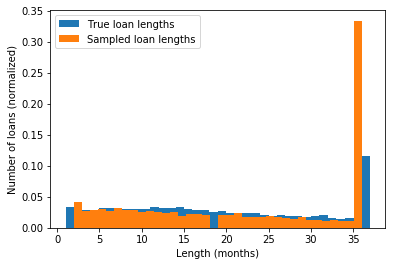

Average length of sampled loans: 21.96 months
Average length of true loans: 18.17 months


In [13]:
plot_sampled_lengths(sampled_trajectories, df)

## Experiment 1 version 2: MLE on extrapolated data

In [173]:
x_all = df.pivot(index='id', columns='age_of_loan', values='loan_status')

In [184]:
x_all[0].isnull().sum()/x_all[0].shape

array([0.97711721])

In [187]:
x_all[~x_all[0].isnull()]

age_of_loan,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
id,,,,,,,,,,,,,,,,,,,,,
377140,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,NaN,NaN
384586,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582543,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699575,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
767952,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773432,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
776851,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780608,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
805835,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
x_all = x_all[x_all[0].isnull()].drop(0, axis=1).fillna(axis=1, method='ffill')

In [149]:
x_all[x_all[1] == 5]

age_of_loan,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
id,,,,,,,,,,,,,,,,,,,,,
251214,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
267976,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
273445,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [160]:
any_issued = pd.DataFrame([x_all[i] == 5 for i in range(1,37)])

In [162]:
x_all[any_issued.any()]

age_of_loan,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
id,,,,,,,,,,,,,,,,,,,,,
251214,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
267976,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
273445,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [172]:
(df.loan_status == 5).sum()

18940

In [168]:
for i in range(1, 37):
    print(x_train[i].value_counts()[5])

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


**Idea 1:** do a trick on x_train to get counts differently than in utils

In [120]:
# didn't get anything working...

**Idea 2:** reshape x_train to put it back in original shape then apply utils

In [121]:
x_train_pivoted = x_train.T.melt().reset_index()

In [122]:
x_train_pivoted['previous_index'] = x_train_pivoted.index - 1

In [123]:
new_transitions =  pd.merge(x_train_pivoted, x_train_pivoted,
                        left_on=['id', 'index'], right_on=['id', 'previous_index'])

In [124]:
new_transition_matrix = pd.crosstab(new_transitions['value_x'], new_transitions['value_y'])

In [125]:
new_transition_matrix

value_y,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
value_x,,,,,,,,
0.0,2225330,0,0,0,0,0,0,0
1.0,681,33350767,3,627892,5153,0,142922,55585
2.0,25814,125,2520,63,0,0,3,458
3.0,0,0,0,9376874,11,0,84,64
4.0,0,244,0,9,91504,0,52,37
5.0,0,0,0,0,0,105,0,0
6.0,4066,28826,0,1803,224,0,109507,106647
7.0,94685,22705,26613,1892,53,0,2954,505525


In [127]:
round(compute_mle(new_transition_matrix), 2)

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,1.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
Current,0.00,0.98,0.00,0.02,0.0,0.0,0.00,0.00
Default,0.89,0.00,0.09,0.00,0.0,0.0,0.00,0.02
Fully Paid,0.00,0.00,0.00,1.00,0.0,0.0,0.00,0.00
In Grace Period,0.00,0.00,0.00,0.00,1.0,0.0,0.00,0.00
Issued,0.00,0.00,0.00,0.00,0.0,1.0,0.00,0.00
Late (16-30 days),0.02,0.11,0.00,0.01,0.0,0.0,0.44,0.42
Late (31-120 days),0.14,0.03,0.04,0.00,0.0,0.0,0.00,0.77


In [141]:
x_train[x_train[36] == 5]

age_of_loan,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
id,,,,,,,,,,,,,,,,,,,,,
251214,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
267976,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
273445,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [145]:
x_train[x_train[1] == 5]

age_of_loan,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
id,,,,,,,,,,,,,,,,,,,,,
251214,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
267976,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
273445,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


## Experiment 2: Stationary Markov Chain with Priors

### 2.1 Model

In [232]:
batch_size = 1000

In [233]:
x, pi_0, pi_T = build_mc_with_priors(n_states, chain_len, batch_size)

### 2.2 Inference (Batch)

@Basil: I load models and inference like this so that I can reload them without restarting the kernel: (you can reload a module but can't reload a function): 

In [230]:
import utils.models, utils.inference

In [231]:
from importlib import reload
reload(utils.models)
reload(utils.inference)

<module 'utils.inference' from '/Users/jeromekafrouni/Documents/Cours/Columbia/Cours/Semestre 3/COMS 6998 Prob Programming/Project/lending-club-analysis/final-project/utils/inference.py'>

**Parameter tuning**

I tried multiple values for n_samples:
- 5 = what we had initially, somewhat converges
- 1000 = too high, blows up the memory 
- 100 = still goes to NaN with default optimizer; with custom optimizer, doesn't seem to help that much
=> setting to 10 for now

Optimizer:
- lr = 0.01 too high, goes to NaN
- anything higher than 0.005 goes to NaN eventually
- 0.005 what he had so far
- 0.001 not much difference
- adding exponential decay of the lr (what's done by default when not specifying lr) doesn't help either

n_epochs:
- Have been using 10 so far

**TODO:** write down the KLqp loss; think about kl_scaling argument??

Running on 5 epochs: starts around loss 100K, dicreases to around 10K, sometimes goes to NaN right before the end. Takes around 1min to train

In [234]:
inferred_matrix, sess, qpi_0, qpi_T = utils.inference.infer_mc_with_priors(
    x_train, x, pi_0, pi_T, n_states, chain_len, batch_size, lr=0.005)

6666/6685 [ 99%] █████████████████████████████  ETA: 0s | Loss: 21095.084Caching experiment2 data...
Retrieved 8 rows, 8 columns in 50.86 seconds


In [235]:
inferred_matrix

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0.173555,0.119204,0.170261,0.066675,0.182625,0.077207,0.093568,0.116904
Current,0.039533,0.690358,0.034501,0.068458,0.036994,0.033462,0.052527,0.044166
Default,0.148018,0.126094,0.110415,0.185631,0.138787,0.127012,0.105277,0.058766
Fully Paid,0.047913,0.116889,0.063637,0.387447,0.098088,0.072300,0.109003,0.104723
In Grace Period,0.165418,0.093664,0.082418,0.111213,0.093256,0.150065,0.158744,0.145223
Issued,0.057334,0.143006,0.125738,0.113974,0.191673,0.188392,0.057334,0.122548
Late (16-30 days),0.155554,0.081519,0.075038,0.098305,0.136376,0.132060,0.108644,0.212503
Late (31-120 days),0.125884,0.147042,0.138182,0.139152,0.078454,0.104236,0.110193,0.156858


### 3.3 Criticism

## Experiment 3: Stationary Markov Chain with Priors, other implementation

= Experiment 2 with TFP's code

In [246]:
from importlib import reload
reload(utils.models)
reload(utils.inference)

<module 'utils.inference' from '/Users/jeromekafrouni/Documents/Cours/Columbia/Cours/Semestre 3/COMS 6998 Prob Programming/Project/lending-club-analysis/final-project/utils/inference.py'>

In [247]:
model, pi_0_2, pi_T_2 = utils.models.build_mc_with_priors_2(
    n_states, chain_len, batch_size=batch_size)

Loss starts around 8K, reaches 3K at 50%, slowly decreases (but with some noise) to around 1K, gets lower than 1K at the very end (TODO/ run with > 1 epochs, but it'll take a while)

Like in exp 2, loss is very unstable... Sometimes results are really good, sometimes not...

In [248]:
inferred_matrix_2, sess_2, qpi_0_2, qpi_T_2 = utils.inference.infer_mc_with_priors_2(
    x_train, model, pi_0_2, pi_T_2, n_states, chain_len, batch_size=batch_size)

1326/1337 [ 99%] █████████████████████████████  ETA: 1s | Loss: 90831.258Caching experiment3 data...
Retrieved 8 rows, 8 columns in 174.61 seconds


In [249]:
inferred_matrix_2

,Charged Off,Current,Default,Fully Paid,In Grace Period,Issued,Late (16-30 days),Late (31-120 days)
Charged Off,0.178300,0.132558,0.146160,0.090049,0.152667,0.082247,0.135308,0.082711
Current,0.141669,0.260492,0.093641,0.093974,0.101702,0.128881,0.087865,0.091776
Default,0.109295,0.099503,0.193689,0.088112,0.173449,0.116353,0.103218,0.116382
Fully Paid,0.059107,0.093554,0.102569,0.199220,0.174758,0.127186,0.128799,0.114808
In Grace Period,0.124730,0.093136,0.162159,0.130785,0.167426,0.153222,0.088986,0.079557
Issued,0.109363,0.056180,0.178650,0.135027,0.147295,0.159111,0.075544,0.138830
Late (16-30 days),0.141695,0.144695,0.108281,0.075666,0.173636,0.071066,0.140033,0.144928
Late (31-120 days),0.105650,0.109268,0.160362,0.112797,0.173998,0.099730,0.113221,0.124975


## Experiment 4: One categorical per timestamp in the chain

In [65]:
# TODO

## Experiment 5: Modeling counts of transitions, as a multinomial

In [66]:
# TODO

## Experiment 6: Segmenting the loans / mixture model

Probably won't have much time to do something decent, maybe we can do the segmentation "by hand" though, i.e. not in edwards...

In [67]:
# TODO

## References

*Machine Learning: A Probabilistic Perspective*, by Kevin P. Murphy, MIT Press, 2012.

In [ ]:
sess.run()